<a href="https://colab.research.google.com/github/AdirGelkop/Bitcoin/blob/main/Bitcoin_Prediction_ML_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Screening AI Project

The goal in our project is to predict Bitcoin's value using regression analysis. The project involves leveraging data from other stock performances to build a predictive model for cryptocurrency trends.

## Initial Preparations

In [1]:
#!pip install yfinance # If not installed, you need to install it.


***Module Imports***

In [2]:
import yfinance as yf
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np


***Importing : Stocks, Commodities, Indices***

In [3]:
# Ticker symbols for selected [Stocks, Commodities, Indices] from yfinance
tickers = {
    'U.S. Dollar Index': 'DX-Y.NYB',   # Dollar Index
    'MicroStrategy': 'MSTR',           # MicroStrategy Incorporated
    'Marathon Digital Holdings': 'MARA', # Marathon Digital Holdings, Inc.
    'Gold Futures': 'GC=F',            # Gold Futures
    'Crude Oil': 'CL=F',               # Crude Oil WTI Futures
    'Copper Futures': 'HG=F',          # Copper Futures
    'S&P 500': '^GSPC',                # S&P 500 Index
    'Ethereum': 'ETH-USD',             # Ethereum (Cryptocurrency)
    'Litecoin': 'LTC-USD',             # Litecoin (Cryptocurrency)
    'Galaxy Digital Holdings': 'GLXY.TO', # Galaxy Digital Holdings Ltd. (Toronto Stock Exchange)
    'Coinbase': 'COIN',                # Coinbase Global, Inc.
    'Ripple': 'XRP-USD'                # Ripple (Cryptocurrency)
}


In [4]:
# Main DataFrame
assets_df = pd.DataFrame()

# Fetching data for assets
print("Fetching data for assets:\n")
for asset_name, ticker in tickers.items():
    print(f"- {asset_name} ({ticker})...", end="")
    try:
        # Download the asset data
        asset_data = yf.download(ticker, start='2014-01-01', interval='1d', progress=False)
        asset_data.reset_index(inplace=True)  # Make 'Date' a simple column

        # Use 'Adj Close' or fallback to 'Close'
        price_column = 'Adj Close' if 'Adj Close' in asset_data.columns else 'Close'
        asset_data['Returns'] = asset_data[price_column].pct_change()

        # Keep 'Date' and 'Returns' columns
        asset_data = asset_data[['Date', 'Returns']].rename(columns={
            'Returns': f"{asset_name}_Returns"
        })

        # Merge into the main DataFrame
        assets_df = asset_data if assets_df.empty else pd.merge(assets_df, asset_data, on='Date', how='left')
        print("Done.")
    except Exception as e:
        print(f"Failed! Error: {e}")

# Flatten any MultiIndex if present
if isinstance(assets_df.columns, pd.MultiIndex):
    assets_df.columns = assets_df.columns.get_level_values(0)

# Remove the name of the columns to avoid "Price" output
assets_df.columns.name = None

# Display the resulting DataFrame
print("\nAssets DataFrame:")
assets_df.head()


Fetching data for assets:

- U.S. Dollar Index (DX-Y.NYB)...Done.
- MicroStrategy (MSTR)...Done.
- Marathon Digital Holdings (MARA)...Done.
- Gold Futures (GC=F)...Done.
- Crude Oil (CL=F)...

<ipython-input-4-7995100bda96>:23: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  assets_df = asset_data if assets_df.empty else pd.merge(assets_df, asset_data, on='Date', how='left')


Done.
- Copper Futures (HG=F)...

<ipython-input-4-7995100bda96>:23: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  assets_df = asset_data if assets_df.empty else pd.merge(assets_df, asset_data, on='Date', how='left')


Done.
- S&P 500 (^GSPC)...Done.
- Ethereum (ETH-USD)...Done.
- Litecoin (LTC-USD)...Done.
- Galaxy Digital Holdings (GLXY.TO)...Done.
- Coinbase (COIN)...

<ipython-input-4-7995100bda96>:23: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  assets_df = asset_data if assets_df.empty else pd.merge(assets_df, asset_data, on='Date', how='left')


Done.
- Ripple (XRP-USD)...Done.

Assets DataFrame:


,Date,U.S. Dollar Index_Returns,MicroStrategy_Returns,Marathon Digital Holdings_Returns,Gold Futures_Returns,Crude Oil_Returns,Copper Futures_Returns,S&P 500_Returns,Ethereum_Returns,Litecoin_Returns,Galaxy Digital Holdings_Returns,Coinbase_Returns,Ripple_Returns
0,2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-03,0.001984,-0.002186,-0.040323,0.010939,-0.015507,-0.007431,-0.000333,NaN,NaN,NaN,NaN,NaN
2,2014-01-06,-0.001733,-0.014766,-0.011765,-0.000484,-0.005641,0.001762,-0.002512,NaN,NaN,NaN,NaN,NaN
3,2014-01-07,0.002232,0.012516,-0.020408,-0.006786,0.002569,-0.000293,0.006082,NaN,NaN,NaN,NaN,NaN
4,2014-01-08,0.002598,-0.004229,0.005208,-0.003335,-0.014306,-0.005130,-0.000212,NaN,NaN,NaN,NaN,NaN


***Importing Bitcoin Data***

In [5]:
# Download Bitcoin data
bitcoin_ticker = 'BTC-USD'

print(f"- Bitcoin ({bitcoin_ticker})...", end="")
try:
    # Fetch Bitcoin data
    bitcoin_df = yf.download(bitcoin_ticker, start='2014-01-01', interval='1d', progress=False)

    # Use 'Adj Close' or fallback to 'Close'
    price_column = 'Adj Close' if 'Adj Close' in bitcoin_df.columns else 'Close'

    # Keep only the fixed price column and reset the index
    bitcoin_df = bitcoin_df[[price_column]]
    bitcoin_df.reset_index(inplace=True)

    # Rename columns for clarity
    bitcoin_df.columns = ['Date', 'Bitcoin_Price']
    print("Done.")
except Exception as e:
    print(f"Failed. Error: {e}")

# Display the Bitcoin DataFrame
print("\nBitcoin DataFrame:\n")
bitcoin_df.head()


- Bitcoin (BTC-USD)...Done.

Bitcoin DataFrame:



,Date,Bitcoin_Price
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014


***Importing : Macroeconomic Indicators***

In [6]:
# Define macroeconomic indicators for pandas_datareader
macro_indicators = {
    'GDP': 'GDP',                      # Gross Domestic Product
    'Money Supply M2': 'WM2NS',        # Money Supply M2
    'Credit Conditions Index': 'DRTSCILM', # Credit Conditions Index
    'Financial Stress Index': 'NFCI',  # National Financial Conditions Index
    '10-Year Inflation-Protected Bonds': 'DFII10', # 10-Year TIPS Bonds
    'High-Yield Corporate Bonds Spread': 'BAMLH0A0HYM2', # High-Yield Corporate Bond Spread
    'Federal Funds Rate': 'FEDFUNDS',  # Federal Funds Rate (Interest Rate)
    'Consumer Price Index (CPI)': 'CPIAUCSL', # Consumer Price Index (Inflation)
    'Market Volatility (VIX)': 'VIXCLS' # Volatility Index
}


In [7]:
# Set the start and end dates
start_date = '2014-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Main DataFrame for macroeconomic indicators
macro_indicators_df = pd.DataFrame()

# Fetch macroeconomic indicators and format them
print("Fetching data for macroeconomic indicators:\n")
for indicator_name, fred_code in macro_indicators.items():
    print(f"- {indicator_name} ({fred_code})...", end="")
    try:
        # Fetch the data from FRED
        data = pdr.DataReader(fred_code, 'fred', start_date, end_date)
        data.reset_index(inplace=True)  # Reset index to make 'DATE' a simple column
        data.rename(columns={'DATE': 'Date', fred_code: indicator_name}, inplace=True)

        # Keep the fixed prices column only
        data = data[['Date', indicator_name]]

        # Merge with the main macro_indicators_df
        if macro_indicators_df.empty:
            macro_indicators_df = data
        else:
            macro_indicators_df = pd.merge(macro_indicators_df, data, on='Date', how='outer')

        print("Done.")
    except Exception as e:
        print(f"Failed! Error: {e}")

# Flatten the column structure
macro_indicators_df.columns = ['Date' if col == 'Date' else col for col in macro_indicators_df.columns]

# Display the resulting DataFrame
print("\nCombined Macro Indicators DataFrame (Fixed Prices):")
macro_indicators_df.head()


Fetching data for macroeconomic indicators:

- GDP (GDP)...Done.
- Money Supply M2 (WM2NS)...Done.
- Credit Conditions Index (DRTSCILM)...Done.
- Financial Stress Index (NFCI)...Done.
- 10-Year Inflation-Protected Bonds (DFII10)...Done.
- High-Yield Corporate Bonds Spread (BAMLH0A0HYM2)...Done.
- Federal Funds Rate (FEDFUNDS)...Done.
- Consumer Price Index (CPI) (CPIAUCSL)...Done.
- Market Volatility (VIX) (VIXCLS)...Done.

Combined Macro Indicators DataFrame (Fixed Prices):


,Date,GDP,Money Supply M2,Credit Conditions Index,Financial Stress Index,10-Year Inflation-Protected Bonds,High-Yield Corporate Bonds Spread,Federal Funds Rate,Consumer Price Index (CPI),Market Volatility (VIX)
0,2014-01-01,17197.738,NaN,-13.7,NaN,NaN,NaN,0.07,235.288,NaN
1,2014-01-02,NaN,NaN,NaN,NaN,0.74,4.00,NaN,NaN,14.23
2,2014-01-03,NaN,NaN,NaN,-0.77881,0.75,3.98,NaN,NaN,13.76
3,2014-01-06,NaN,11191.2,NaN,NaN,0.72,3.96,NaN,NaN,13.55
4,2014-01-07,NaN,NaN,NaN,NaN,0.70,3.92,NaN,NaN,12.92


***Merging all 3 Dataframes : assets_df,macro_indicators_df, bitcoin_df***

In [8]:
# Rename 'DATE' to 'Date' in macro_indicators_df
macro_indicators_df.rename(columns={'DATE': 'Date'}, inplace=True)

# Drop existing index if needed and reset index for all DataFrames
assets_df = assets_df.reset_index(drop=True)
bitcoin_df = bitcoin_df.reset_index(drop=True)

# Merge all DataFrames on 'Date'
merged_df = pd.merge(macro_indicators_df, assets_df, on='Date', how='left')
merged_df = pd.merge(merged_df, bitcoin_df, on='Date', how='left')

# Display the merged DataFrame without filling missing values
print("\nFinal Merged DataFrame (without ffill):\n")
merged_df.head()



Final Merged DataFrame (without ffill):



,Date,GDP,Money Supply M2,Credit Conditions Index,Financial Stress Index,10-Year Inflation-Protected Bonds,High-Yield Corporate Bonds Spread,Federal Funds Rate,Consumer Price Index (CPI),Market Volatility (VIX),...,Gold Futures_Returns,Crude Oil_Returns,Copper Futures_Returns,S&P 500_Returns,Ethereum_Returns,Litecoin_Returns,Galaxy Digital Holdings_Returns,Coinbase_Returns,Ripple_Returns,Bitcoin_Price
0,2014-01-01,17197.738,NaN,-13.7,NaN,NaN,NaN,0.07,235.288,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-02,NaN,NaN,NaN,NaN,0.74,4.00,NaN,NaN,14.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-01-03,NaN,NaN,NaN,-0.77881,0.75,3.98,NaN,NaN,13.76,...,0.010939,-0.015507,-0.007431,-0.000333,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-01-06,NaN,11191.2,NaN,NaN,0.72,3.96,NaN,NaN,13.55,...,-0.000484,-0.005641,0.001762,-0.002512,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-01-07,NaN,NaN,NaN,NaN,0.70,3.92,NaN,NaN,12.92,...,-0.006786,0.002569,-0.000293,0.006082,NaN,NaN,NaN,NaN,NaN,NaN


***Taking care of NaN values***

In [9]:
# Forward fill (ffill) is the primary method to handle missing data, as it assumes continuity in economic returns.
merged_df.ffill(inplace=True)

# Check if any NaNs remain after ffill and handle them
if merged_df.isna().sum().sum() > 0:
    # Backward fill (bfill) is used as a secondary option for isolated NaNs at the beginning of the dataset.
    # In economics, returns often follow patterns that depend on historical values (continuity). Filling missing values based on nearby known data (via ffill and bfill) aligns with how returns behave in the real world.
    merged_df.bfill(inplace=True)

# Display the filled DataFrame
print("\nMerged DataFrame after filling missing values:\n")
merged_df.head()



Merged DataFrame after filling missing values:



,Date,GDP,Money Supply M2,Credit Conditions Index,Financial Stress Index,10-Year Inflation-Protected Bonds,High-Yield Corporate Bonds Spread,Federal Funds Rate,Consumer Price Index (CPI),Market Volatility (VIX),...,Gold Futures_Returns,Crude Oil_Returns,Copper Futures_Returns,S&P 500_Returns,Ethereum_Returns,Litecoin_Returns,Galaxy Digital Holdings_Returns,Coinbase_Returns,Ripple_Returns,Bitcoin_Price
0,2014-01-01,17197.738,11191.2,-13.7,-0.77881,0.74,4.00,0.07,235.288,14.23,...,0.010939,-0.015507,-0.007431,-0.000333,-0.067411,-0.0738,-0.026667,-0.016845,-0.0506,457.334015
1,2014-01-02,17197.738,11191.2,-13.7,-0.77881,0.74,4.00,0.07,235.288,14.23,...,0.010939,-0.015507,-0.007431,-0.000333,-0.067411,-0.0738,-0.026667,-0.016845,-0.0506,457.334015
2,2014-01-03,17197.738,11191.2,-13.7,-0.77881,0.75,3.98,0.07,235.288,13.76,...,0.010939,-0.015507,-0.007431,-0.000333,-0.067411,-0.0738,-0.026667,-0.016845,-0.0506,457.334015
3,2014-01-06,17197.738,11191.2,-13.7,-0.77881,0.72,3.96,0.07,235.288,13.55,...,-0.000484,-0.005641,0.001762,-0.002512,-0.067411,-0.0738,-0.026667,-0.016845,-0.0506,457.334015
4,2014-01-07,17197.738,11191.2,-13.7,-0.77881,0.70,3.92,0.07,235.288,12.92,...,-0.006786,0.002569,-0.000293,0.006082,-0.067411,-0.0738,-0.026667,-0.016845,-0.0506,457.334015


***Feature Engineering - Adding 3 Features : Copper_to_Gold_Ratio, Money_to_Dollar_Ratio, Global_Velocity***

In [10]:
# Fetch and Prepare Price Data
def fetch_price_data(ticker, column_name):
    data = yf.download(ticker, start='2014-01-01', interval='1d', progress=False)
    price_column = 'Adj Close' if 'Adj Close' in data.columns else 'Close'
    return data[[price_column]].rename(columns={price_column: column_name})

data_sources = {
    'Copper_Price': 'HG=F',
    'Gold_Price': 'GC=F',
    'US_Dollar_Price': 'DX-Y.NYB'
}

# Combine required price data
required_prices_df = pd.concat(
    [fetch_price_data(ticker, name) for name, ticker in data_sources.items()],
    axis=1
).reset_index()  # Reset index after combining

# Flatten MultiIndex columns in required_prices_df
if isinstance(required_prices_df.columns, pd.MultiIndex):
    required_prices_df.columns = required_prices_df.columns.get_level_values(0)

# Rename and ensure Date alignment
required_prices_df.rename(columns={'index': 'Date'}, inplace=True)
required_prices_df['Date'] = pd.to_datetime(required_prices_df['Date'])

# Ensure Date alignment in merged_df
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Ensure indices are flat for merging
required_prices_df = required_prices_df.reset_index(drop=True)
merged_df = merged_df.reset_index(drop=True)

required_prices_df.head()



Price,Date,Copper_Price,Gold_Price,US_Dollar_Price
0,2014-01-02,3.4315,1225.000000,80.629997
1,2014-01-03,3.4060,1238.400024,80.790001
2,2014-01-06,3.4120,1237.800049,80.650002
3,2014-01-07,3.4110,1229.400024,80.830002
4,2014-01-08,3.3935,1225.300049,81.040001


In [11]:
# Calculate Features and Merge
# Merge required_prices_df into merged_df on Date for calculations only
calculation_df = pd.merge(merged_df[['Date', 'GDP', 'Money Supply M2']], required_prices_df, on='Date', how='left')

# Forward-fill and Backward-fill missing values in required_prices_df
calculation_df.fillna(method='ffill', inplace=True)
calculation_df.fillna(method='bfill', inplace=True)

calculation_df.head()


<ipython-input-11-57023e5b84d1>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  calculation_df.fillna(method='ffill', inplace=True)
<ipython-input-11-57023e5b84d1>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  calculation_df.fillna(method='bfill', inplace=True)


,Date,GDP,Money Supply M2,Copper_Price,Gold_Price,US_Dollar_Price
0,2014-01-01,17197.738,11191.2,3.4315,1225.000000,80.629997
1,2014-01-02,17197.738,11191.2,3.4315,1225.000000,80.629997
2,2014-01-03,17197.738,11191.2,3.4060,1238.400024,80.790001
3,2014-01-06,17197.738,11191.2,3.4120,1237.800049,80.650002
4,2014-01-07,17197.738,11191.2,3.4110,1229.400024,80.830002


In [12]:
# Calculate the new features directly
merged_df['Copper_to_Gold_Ratio'] = calculation_df['Copper_Price'] / calculation_df['Gold_Price']
merged_df['Money_to_Dollar_Ratio'] = calculation_df['Money Supply M2'] / calculation_df['US_Dollar_Price']
merged_df['Global_Velocity'] = calculation_df['GDP'] / calculation_df['Money Supply M2']

# Drop unnecessary intermediate columns
merged_df = merged_df.drop(columns=['Copper_Price', 'Gold_Price', 'US_Dollar_Price'], errors='ignore')

# Move Bitcoin_Price to the last column if it exists
if 'Bitcoin_Price' in merged_df.columns:
    merged_df['Bitcoin_Price'] = merged_df.pop('Bitcoin_Price')

# Display the updated DataFrame
print("\nUpdated merged_df with new features:")
merged_df.head()



Updated merged_df with new features:


,Date,GDP,Money Supply M2,Credit Conditions Index,Financial Stress Index,10-Year Inflation-Protected Bonds,High-Yield Corporate Bonds Spread,Federal Funds Rate,Consumer Price Index (CPI),Market Volatility (VIX),...,S&P 500_Returns,Ethereum_Returns,Litecoin_Returns,Galaxy Digital Holdings_Returns,Coinbase_Returns,Ripple_Returns,Copper_to_Gold_Ratio,Money_to_Dollar_Ratio,Global_Velocity,Bitcoin_Price
0,2014-01-01,17197.738,11191.2,-13.7,-0.77881,0.74,4.00,0.07,235.288,14.23,...,-0.000333,-0.067411,-0.0738,-0.026667,-0.016845,-0.0506,0.002801,138.796979,1.53672,457.334015
1,2014-01-02,17197.738,11191.2,-13.7,-0.77881,0.74,4.00,0.07,235.288,14.23,...,-0.000333,-0.067411,-0.0738,-0.026667,-0.016845,-0.0506,0.002801,138.796979,1.53672,457.334015
2,2014-01-03,17197.738,11191.2,-13.7,-0.77881,0.75,3.98,0.07,235.288,13.76,...,-0.000333,-0.067411,-0.0738,-0.026667,-0.016845,-0.0506,0.002750,138.522093,1.53672,457.334015
3,2014-01-06,17197.738,11191.2,-13.7,-0.77881,0.72,3.96,0.07,235.288,13.55,...,-0.002512,-0.067411,-0.0738,-0.026667,-0.016845,-0.0506,0.002757,138.762552,1.53672,457.334015
4,2014-01-07,17197.738,11191.2,-13.7,-0.77881,0.70,3.92,0.07,235.288,12.92,...,0.006082,-0.067411,-0.0738,-0.026667,-0.016845,-0.0506,0.002775,138.453541,1.53672,457.334015


**Visualizations**

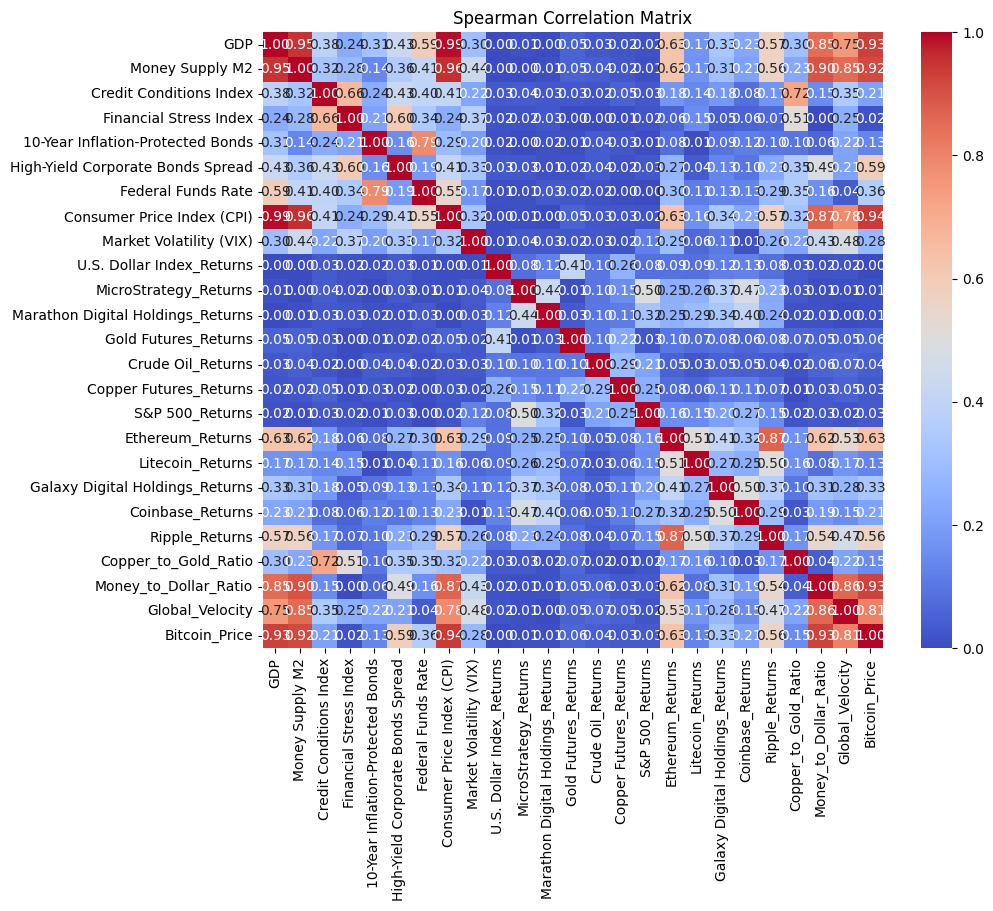

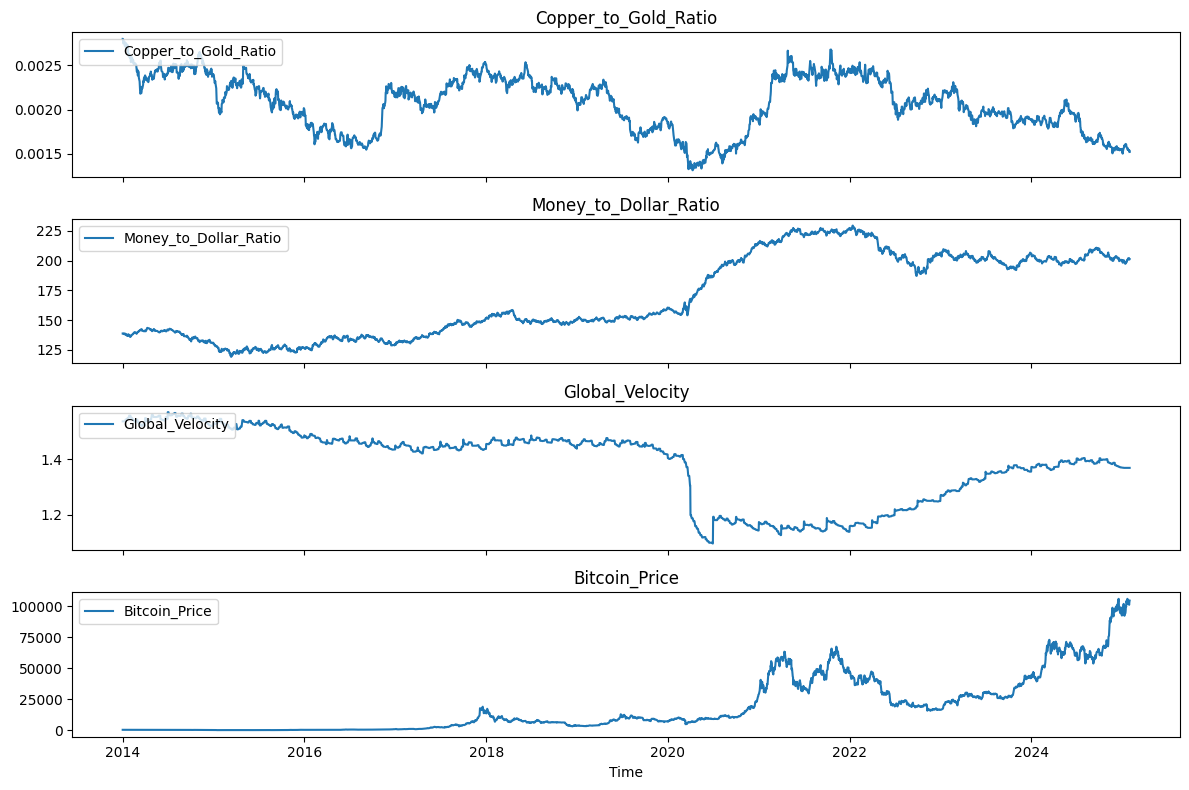


Spearman Correlations with Bitcoin_Price (sorted):

Bitcoin_Price                        1.000000
Consumer Price Index (CPI)           0.938212
GDP                                  0.930419
Money_to_Dollar_Ratio                0.927520
Money Supply M2                      0.917189
Global_Velocity                      0.805353
Ethereum_Returns                     0.629314
High-Yield Corporate Bonds Spread    0.586760
Ripple_Returns                       0.561962
Federal Funds Rate                   0.360061
Galaxy Digital Holdings_Returns      0.332722
Market Volatility (VIX)              0.280976
Coinbase_Returns                     0.212809
Credit Conditions Index              0.207301
Copper_to_Gold_Ratio                 0.150443
10-Year Inflation-Protected Bonds    0.134559
Litecoin_Returns                     0.129167
Gold Futures_Returns                 0.059684
Crude Oil_Returns                    0.042243
Copper Futures_Returns               0.034143
S&P 500_Returns            

In [13]:
# Visualization Section

# Drop 'Date' column temporarily for correlation calculation
correlation_data = merged_df.drop(columns=['Date'], errors='ignore')

# Correlation Matrix Heatmap (using Spearman correlation for time series)
plt.figure(figsize=(10, 8))
correlation_matrix = correlation_data.corr(method='spearman').abs()  # Absolute values for correlations
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=0, vmax=1)
plt.title("Spearman Correlation Matrix")
plt.show()

# Time Series Trends for Financial Features
financial_features = ['Copper_to_Gold_Ratio', 'Money_to_Dollar_Ratio', 'Global_Velocity', 'Bitcoin_Price']
fig, axs = plt.subplots(len(financial_features), 1, figsize=(12, 8), sharex=True)

for i, feature in enumerate(financial_features):
    axs[i].plot(merged_df['Date'], merged_df[feature], label=feature)
    axs[i].set_title(feature)
    axs[i].legend(loc='upper left')

plt.xlabel("Time")
plt.tight_layout()
plt.show()

# Sorted Bitcoin Correlations
bitcoin_correlation = correlation_matrix['Bitcoin_Price'].sort_values(ascending=False)
print("\nSpearman Correlations with Bitcoin_Price (sorted):\n")
print(bitcoin_correlation)


**Preparing The 'merged_df' For Model Run**

In [14]:
# Shift Bitcoin_Price column upwards by one row to predict next day's price
merged_df['Bitcoin_Price'] = merged_df['Bitcoin_Price'].shift(-1)

# Drop the Date column as it is not a feature
merged_df = merged_df.drop(columns=['Date'], errors='ignore')

# Separate the last row for future prediction
future_row = merged_df.iloc[[-1]]
merged_df = merged_df.iloc[:-1]

# Split the data into features (X) and prediction target (y)
X = merged_df.drop(columns=['Bitcoin_Price'])  # Features
y = merged_df['Bitcoin_Price']                # Target variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets for verification
print("Training set shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Testing set shape (X_test, y_test):", X_test.shape, y_test.shape)

# Display the future row for prediction verification
print("\nFuture row for prediction:")
future_row


Training set shape (X_train, y_train): (2372, 24) (2372,)
Testing set shape (X_test, y_test): (594, 24) (594,)

Future row for prediction:


,GDP,Money Supply M2,Credit Conditions Index,Financial Stress Index,10-Year Inflation-Protected Bonds,High-Yield Corporate Bonds Spread,Federal Funds Rate,Consumer Price Index (CPI),Market Volatility (VIX),U.S. Dollar Index_Returns,...,S&P 500_Returns,Ethereum_Returns,Litecoin_Returns,Galaxy Digital Holdings_Returns,Coinbase_Returns,Ripple_Returns,Copper_to_Gold_Ratio,Money_to_Dollar_Ratio,Global_Velocity,Bitcoin_Price
2966,29700.58,21692.1,0.0,-0.65143,2.14,2.67,4.48,317.685,15.84,-0.001852,...,0.005275,0.043296,0.122926,0.00825,0.035395,0.020459,0.001519,201.225412,1.369189,NaN


**Random Forest Model**

In [25]:
# Define base models for stacking
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),  # Random Forest
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42))  # Gradient Boosting
]

# Stacking Model: Combines multiple models using Ridge Regression as final estimator
stacked_model = StackingRegressor(estimators=estimators, final_estimator=Ridge())

# Train the stacked model
stacked_model.fit(X_train, y_train)

# Predict on the test set
stacked_pred = stacked_model.predict(X_test)

# Evaluate the stacked model
stacked_rmse = np.sqrt(mean_squared_error(y_test, stacked_pred))
stacked_r2 = r2_score(y_test, stacked_pred)

print("\n📌 **Stacked Model Results:**")
print(f"RMSE: {stacked_rmse:.4f}")
print(f"R² Score: {stacked_r2:.4f}")

# Evaluate individual models
rf_pred = estimators[0][1].fit(X_train, y_train).predict(X_test)
gb_pred = estimators[1][1].fit(X_train, y_train).predict(X_test)

# Compute R² Score for each model
rf_r2 = r2_score(y_test, rf_pred)
gb_r2 = r2_score(y_test, gb_pred)

# Print Performance Comparison using R² Score
# Best model should have highest R²
print("\n📊 **Model Performance Comparison (R² Score):**")
print(f"Random Forest R²: {rf_r2:.4f}")
print(f"Gradient Boosting R²: {gb_r2:.4f}")
print(f"Stacked Model R²: {stacked_r2:.4f}")



📌 **Stacked Model Results:**
RMSE: 1273.3030
R² Score: 0.9970

📊 **Model Performance Comparison (R² Score):**
Random Forest R²: 0.9970
Gradient Boosting R²: 0.9926
Stacked Model R²: 0.9970


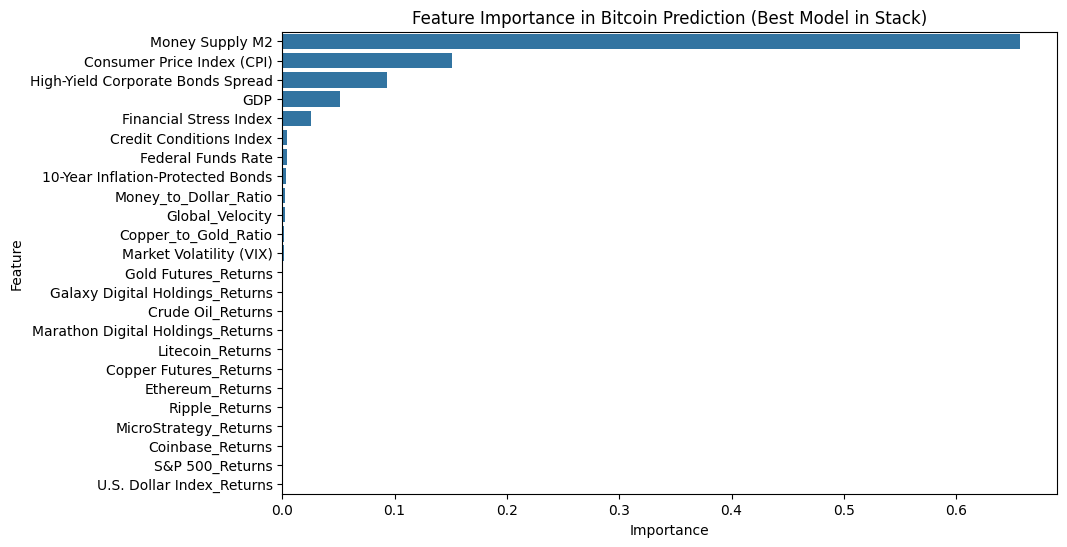

In [27]:
# Extract feature importances from the best base model (Random Forest in this case)
best_model = stacked_model.estimators_[0]  # Selecting the first model in the stack (RF)
importances = best_model.feature_importances_

# Create DataFrame
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importance in Bitcoin Prediction (Best Model in Stack)")
plt.show()


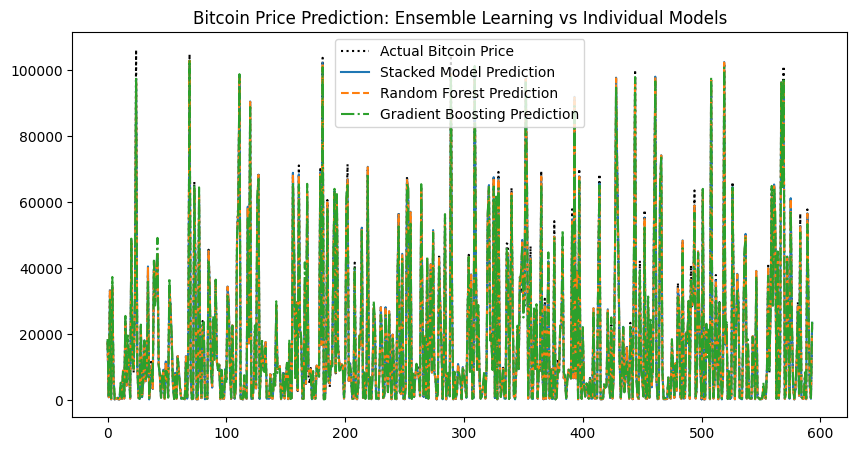

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual Bitcoin Price", color="black", linestyle="dotted")
plt.plot(stacked_pred, label="Stacked Model Prediction", linestyle="solid")
plt.plot(rf_pred, label="Random Forest Prediction", linestyle="dashed")
plt.plot(gb_pred, label="Gradient Boosting Prediction", linestyle="dashdot")

plt.title("Bitcoin Price Prediction: Ensemble Learning vs Individual Models")
plt.legend()
plt.show()


In [30]:
# Predict the Bitcoin price for the future row
future_prediction = stacked_model.predict(future_row.drop(columns=['Bitcoin_Price'], errors='ignore'))
print("\nPredicted Bitcoin Price for the future row [USD]:", future_prediction)



Predicted Bitcoin Price for the future row [USD]: [102565.28462867]
